In [1]:
#ep25
#bs4

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, Input, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
IMG_SIZE = (224, 224)
#BATCH_SIZE = 4
#EPOCHS = 80
IMG_DIR = 'C:/Users/User/again/png_images'
MASK_DIR = 'C:/Users/User/again/masks'
LABEL_CSV = 'labels.csv'

In [4]:
df = pd.read_csv(LABEL_CSV)
df['label'] = df['label'] - df['label'].min()  # ensure labels start at 0

In [5]:
def load_image_mask(img_path, mask_path):
    # Load grayscale image
    image = load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
    image = img_to_array(image)
    image = (image - np.mean(image)) / (np.std(image) + 1e-5)  # normalize

    # Load mask
    mask = load_img(mask_path, target_size=IMG_SIZE, color_mode="grayscale")
    mask = img_to_array(mask)

    # Binary tumor mask: 1 = any tumor, 0 = background
    mask = np.where(mask > 0, 1, 0).astype(np.uint8)

    return image, mask

In [6]:
images, masks = [], []

for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["filename"])
    mask_path = os.path.join(MASK_DIR, row["filename"])

    img, mask = load_image_mask(img_path, mask_path)
    images.append(img)
    masks.append(mask)


In [7]:
X = np.array(images, dtype=np.float32)
y = np.array(masks, dtype=np.float32)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
tumor_indices = [i for i in range(len(y_train)) if np.sum(y_train[i]) > 0]

X_train_tumor = X_train[tumor_indices]
y_train_tumor = y_train[tumor_indices]

In [10]:
def build_unet_binary(input_shape=(224,224,1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(b)
    
    # Decoder
    u1 = layers.UpSampling2D()(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    return Model(inputs, outputs)

In [11]:
model = build_unet_binary(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))

In [12]:
bce = tf.keras.losses.BinaryCrossentropy()

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

In [13]:
def focal_loss(y_true, y_pred, alpha=0.75, gamma=2.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-6, 1 - 1e-6)

    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)

    return tf.reduce_mean(loss)

In [14]:
def dice_focal_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

In [15]:
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)  # binarize predictions

    intersection = tf.reduce_sum(y_true * y_pred_bin, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred_bin, axis=[1,2,3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=dice_focal_loss,
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=4
)

Epoch 1/25
613/613 ━━━━━━━━━━━━━━━━━━━━ 770s 1s/step - accuracy: 0.9812 - loss: 0.9618 - val_accuracy: 0.9780 - val_loss: 0.9291
Epoch 2/25
613/613 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.9676 - loss: 0.9272 - val_accuracy: 0.9782 - val_loss: 0.9244
Epoch 3/25
613/613 ━━━━━━━━━━━━━━━━━━━━ 744s 1s/step - accuracy: 0.9611 - loss: 0.9180 - val_accuracy: 0.9663 - val_loss: 0.9017
Epoch 4/25
613/613 ━━━━━━━━━━━━━━━━━━━━ 745s 1s/step - accuracy: 0.9561 - loss: 0.9003 - val_accuracy: 0.9309 - val_loss: 0.9139
Epoch 5/25
613/613 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - accuracy: 0.9600 - loss: 0.8853 - val_accuracy: 0.9718 - val_loss: 0.8893
Epoch 6/25
613/613 ━━━━━━━━━━━━━━━━━━━━ 739s 1s/step - accuracy: 0.9598 - loss: 0.8646 - val_accuracy: 0.9593 - val_loss: 0.8678
Epoch 7/25
613/613 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - accuracy: 0.9621 - loss: 0.8517 - val_accuracy: 0.9496 - val_loss: 0.8645
Epoch 8/25
613/613 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.9636 - loss: 0.8438 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


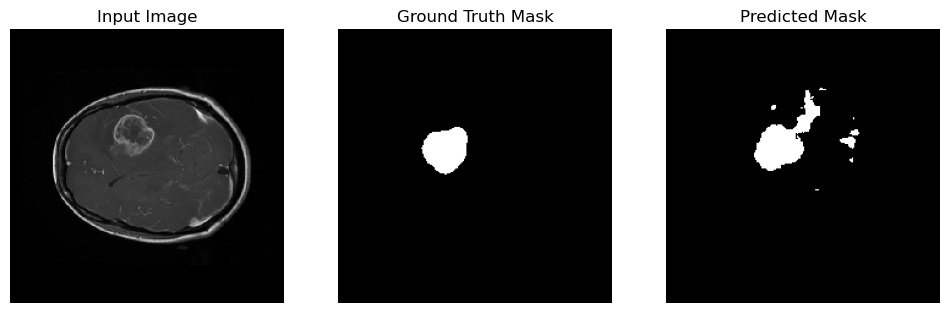

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


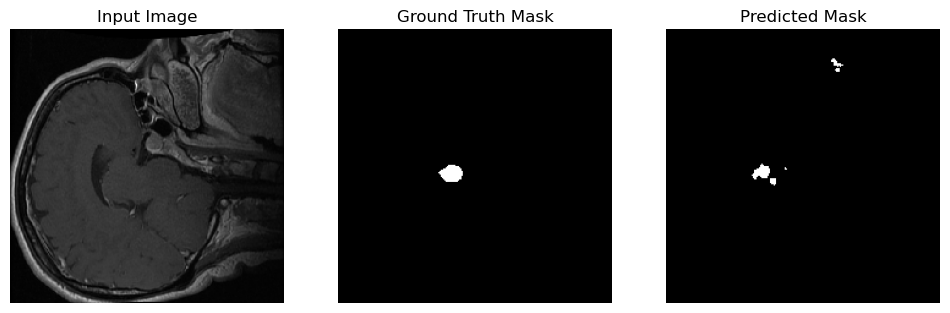

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


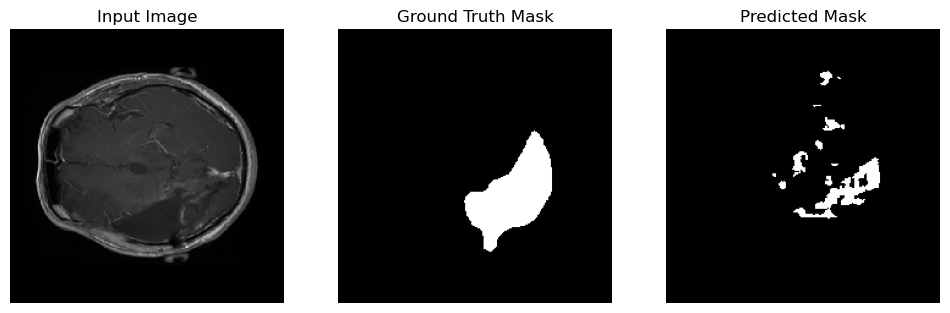

In [18]:
def plot_prediction(index):
    pred_mask = model.predict(X_val[index:index+1])[0,...,0]
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(X_val[index,...,0], cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(y_val[index,...,0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(pred_mask_bin, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.show()

# Example: plot the first 3 validation predictions
for i in range(3):
    plot_prediction(i)

In [19]:
def dice_score(y_true, y_pred, smooth=1e-6):
    y_pred_bin = (y_pred > 0.3).astype(np.float32)
    intersection = np.sum(y_true * y_pred_bin)
    union = np.sum(y_true) + np.sum(y_pred_bin)
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice

In [20]:
def iou_score(y_true, y_pred, smooth=1e-6):
    y_pred_bin = (y_pred > 0.3).astype(np.float32)
    intersection = np.sum(y_true * y_pred_bin)
    union = np.sum(y_true) + np.sum(y_pred_bin) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [22]:
dice_list = []
iou_list = []
BATCH_SIZE = 4
preds = model.predict(X_val, batch_size=BATCH_SIZE)

for i in range(len(X_val)):
    dice_list.append(dice_score(y_val[i], preds[i]))
    iou_list.append(iou_score(y_val[i], preds[i]))

mean_dice = np.mean(dice_list)
mean_iou = np.mean(iou_list)

print(f"Dice Score: {mean_dice:.4f}")
print(f"IoU Score: {mean_iou:.4f}")

154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step
Dice Score: 0.2558
IoU Score: 0.1660


In [23]:
def pixel_accuracy(y_true, y_pred):
    y_pred_bin = (y_pred > 0.3).astype(np.float32)
    return np.mean(y_true == y_pred_bin)

pixel_accs = [pixel_accuracy(y_val[i], model.predict(X_val[i:i+1])[0]) for i in range(len(X_val))]
print(f"Mean Pixel Accuracy: {np.mean(pixel_accs):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.save("brain_tumor_segmentation_model.keras")

In [ ]:
model.save_weights("brain_tumor_seg.weights.h5")